# Experiments with PCA
 - Dataset: [SVNH Dataset](http://ufldl.stanford.edu/housenumbers/) (Format 2)

#### a) Perform PCA on SVHN data set. Find how many top eigenvectors are required to keep the proportion of variance above 0.9. Plot PoV against number of eigenvectors.

In [37]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np

# Set the random seed
np.random.seed(42)

### Data Preparation

In [38]:
train_data = './data/train_32x32.mat'
test_data = './data/test_32x32.mat'

train = sio.loadmat(train_data)
test = sio.loadmat(test_data)

train_X, train_y = train['X'], train['y']
test_X, test_y = test['X'], test['y']

print(f'Before reshaping: train_X: {train_X.shape}, train_y: {train_y.shape}')
print(f'Before reshaping: test_X: {test_X.shape}, test_y: {test_y.shape}')

# Reshape the data to NxHxWxC
train_X = train_X.transpose((3, 0, 1, 2))
test_X = test_X.transpose((3, 0, 1, 2))
# Make test_y and train_y into a 1D array
train_y = train_y.reshape(-1)
test_y = test_y.reshape(-1)

# Change all the 10s in the labels to 0s
train_y[train_y == 10] = 0
test_y[test_y == 10] = 0

print(f'After reshaping: train_X: {train_X.shape}, train_y: {train_y.shape}')
print(f'After reshaping: test_X: {test_X.shape}, test_y: {test_y.shape}')

Before reshaping: train_X: (32, 32, 3, 73257), train_y: (73257, 1)
Before reshaping: test_X: (32, 32, 3, 26032), test_y: (26032, 1)
After reshaping: train_X: (73257, 32, 32, 3), train_y: (73257,)
After reshaping: test_X: (26032, 32, 32, 3), test_y: (26032,)


Image shape: (32, 32, 3), Label: 3


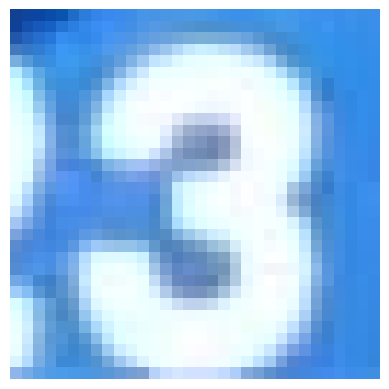

In [39]:
image, label = train_X[3], train_y[3]
print(f'Image shape: {image.shape}, Label: {label}')

# Visualise image with matplotlib
plt.imshow(image)
plt.axis('off')
plt.show()

In [40]:
# Pick 2500 samples from each class
print(f'min: {np.min(train_y)}, max: {np.max(train_y)}')
X_samples, y_samples = [], []
for i in range(10):
    indices = np.where(train_y == i)[0]
    random_indices = np.random.choice(indices, 2500, replace=False)
    X_samples.append(train_X[random_indices])
    y_samples.append(train_y[random_indices])

train_X, train_y = np.concatenate(X_samples), np.concatenate(y_samples)
print(f'After sampling: train_X: {train_X.shape}, train_y: {train_y.shape}')

min: 0, max: 9
After sampling: train_X: (25000, 32, 32, 3), train_y: (25000,)


### PCA

In [41]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Set seed
np.random.seed(42)

In [42]:
pca = PCA()
pca.fit(train_X.reshape(train_X.shape[0], -1))
print(f'Shape of matrix of eigenvectors: {pca.components_.shape}')
print(f'Percentages of variance: {pca.explained_variance_ratio_}')

Shape of matrix of eigenvectors: (3072, 3072)
Percentages of variance: [5.79920018e-01 5.85990357e-02 5.12057637e-02 ... 8.72926471e-09
 8.62118220e-09 8.49975562e-09]


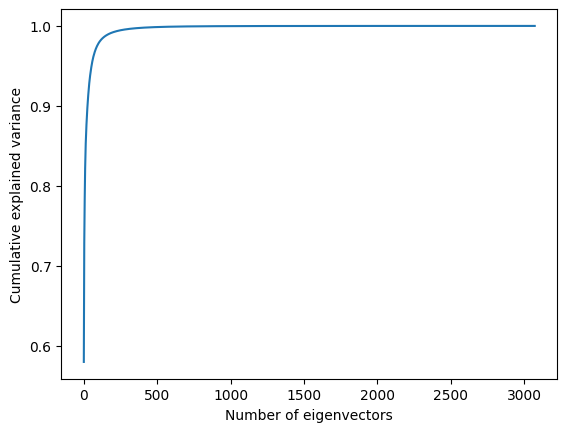

In [43]:
# Plot POV
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of eigenvectors')
plt.ylabel('Cumulative explained variance')
plt.show()

In [44]:
# Find out how many eigenvectors constitute a POV of 0.9
num = 1
for i in np.cumsum(pca.explained_variance_ratio_):
    if i > 0.9:
        break
    num += 1
print(num)

26


#### b) Visualize top 10 eigenvectors and provide reconstruction of 10 SVHN samples (one from each class) using top 10 eigenvectors.

In [45]:
def min_max_normalise(X):
    """Normalize X to constrain all values between 0 and 1"""
    return (X - np.min(X)) / (np.max(X) - np.min(X))

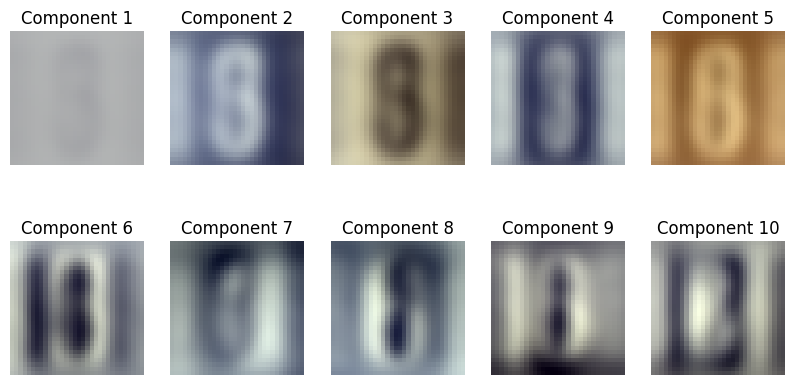

In [46]:
top_10 = min_max_normalise(pca.components_[:10])

fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, ax in enumerate(axes.flat):
    ax.imshow(top_10[i].reshape(32, 32, 3))
    ax.axis('off')
    ax.set_title(f'Component {i+1}')
plt.show()

### Reconstruction using top 10 eigenvectors

In [47]:
# Find indexes of 1 sample from each class
indices = []
for i in range(10):
    indices.append(np.where(train_y == i)[0][0])


# PCA for 10 components
pca = PCA(n_components=10)
pca.fit(train_X.reshape(train_X.shape[0], -1))
print(f'Shape of matrix of eigenvectors: {pca.components_.shape}')
print(f'Percentages of variance: {pca.explained_variance_ratio_}')

Shape of matrix of eigenvectors: (10, 3072)
Percentages of variance: [0.57992002 0.05859904 0.05120576 0.03859269 0.021712   0.0177489
 0.01550321 0.01516155 0.01238849 0.01126745]


Text(0.5, 0.98, 'Original data')

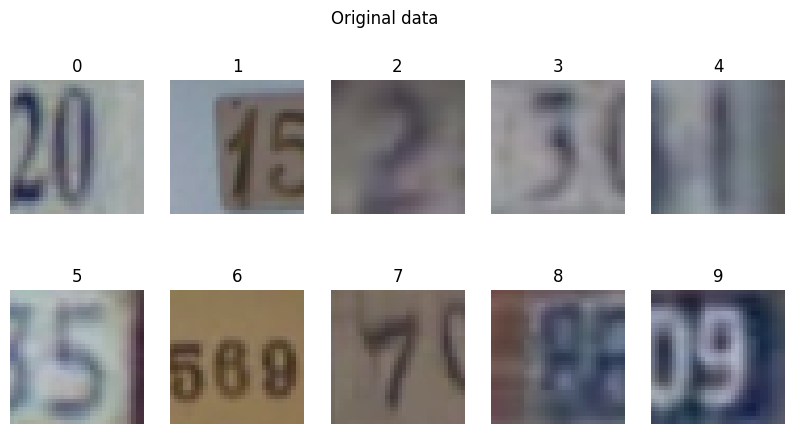

In [48]:
# Display original data
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, ax in enumerate(axes.flat):
    ax.imshow(train_X[indices[i]].reshape(32, 32, 3))
    ax.axis('off')
    ax.set_title(f'{train_y[indices[i]]}')
plt.suptitle('Original data')

Text(0.5, 0.98, 'Reconstructed data')

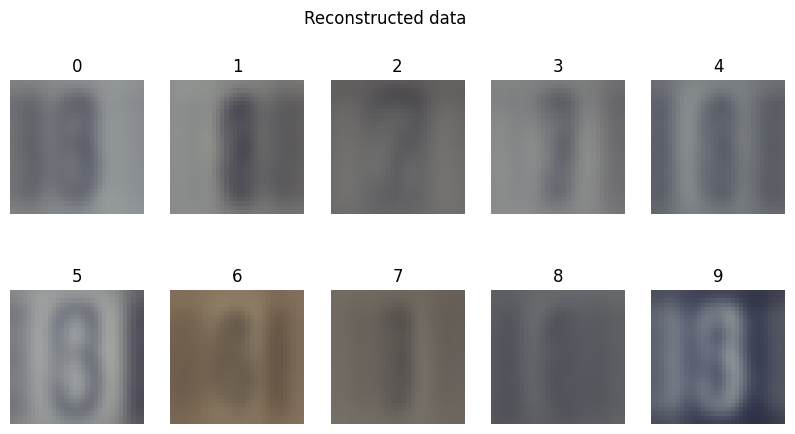

In [49]:
train_X_transformed = pca.transform(train_X.reshape(train_X.shape[0], -1))
train_X_hat = min_max_normalise(pca.inverse_transform(train_X_transformed))

# Display reconstructed data
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, ax in enumerate(axes.flat):
    ax.imshow(train_X_hat[indices[i]].reshape(32, 32, 3))
    ax.axis('off')
    ax.set_title(f'{train_y[indices[i]]}')
plt.suptitle('Reconstructed data')

#### c) Run k-NN (for k=5 and k=7) on raw data and data obtained after PCA dimensionality reduction for dimension as found in part (a) and for dimension 10 as in part (b). Provide the accuracy of the predictions on the test data set for these various cases and discuss your observations.

In [58]:
from sklearn.neighbors import KNeighborsClassifier

In [61]:
# First fit on raw data

knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(train_X.reshape(train_X.shape[0], -1), train_y) 
accuracy_5 = knn.score(test_X.reshape(test_X.shape[0], -1), test_y) # Find accuracy on test set

# Repeat for k=7

knn = KNeighborsClassifier(n_neighbors=7)

knn.fit(train_X.reshape(train_X.shape[0], -1), train_y) 
accuracy_7 = knn.score(test_X.reshape(test_X.shape[0], -1), test_y)

print(f'Accuracy with k=5: {accuracy_5}, Accuracy with k=7: {accuracy_7}')

Accuracy with k=5: 0.3945912722802704, Accuracy with k=7: 0.40769053472649047


In [55]:
# Fit on transformed data (first with components=26, as found in part a) )

# PCA for 26 components
pca = PCA(n_components=26)
pca.fit(train_X.reshape(train_X.shape[0], -1))

knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(pca.transform(train_X.reshape(train_X.shape[0], -1)), train_y)
accuracy_5 = knn.score(pca.transform(test_X.reshape(test_X.shape[0], -1)), test_y) # Find accuracy on test set

# Repeat for k=7

knn = KNeighborsClassifier(n_neighbors=7)

knn.fit(pca.transform(train_X.reshape(train_X.shape[0], -1)), train_y)
accuracy_7 = knn.score(pca.transform(test_X.reshape(test_X.shape[0], -1)), test_y)

print(f'Accuracy with k=5: {accuracy_5}, Accuracy with k=7: {accuracy_7}')

Accuracy with k=5: 0.3962430854333128, Accuracy with k=7: 0.4066917639827904


In [62]:
# Fit on transformed data with 10 components

# PCA for 10 components
pca = PCA(n_components=10)
pca.fit(train_X.reshape(train_X.shape[0], -1))

knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(pca.transform(train_X.reshape(train_X.shape[0], -1)), train_y)
accuracy_5 = knn.score(pca.transform(test_X.reshape(test_X.shape[0], -1)), test_y) # Find accuracy on test set

# Repeat for k=7

knn = KNeighborsClassifier(n_neighbors=7)

knn.fit(pca.transform(train_X.reshape(train_X.shape[0], -1)), train_y)
accuracy_7 = knn.score(pca.transform(test_X.reshape(test_X.shape[0], -1)), test_y)

print(f'Accuracy with k=5: {accuracy_5}, Accuracy with k=7: {accuracy_7}')

Accuracy with k=5: 0.24804087277197295, Accuracy with k=7: 0.2593346650276583


#### Explanation
As can be seen, the accuracies are similar for the raw data and data transformed to $26$ dimensions using PCA. This is because we've retained the eigenvectors with a PoV $> 0.9$, so most of the information is retained. However, when we reduce the dimensionality to $10$, the accuracy drops significantly. This is because we've lost a lot of the information in this case.